# Predicting Chronic Kidney Disease: Data Wrangling

This project combines data from the Center for Disease Control's [500 Cities: Local Data for Better Health](https://www.cdc.gov/500cities/) and the U.S. Census Bureau's [American Community Survey 5-year Data](https://www.census.gov/data/developers/data-sets/acs-5year.html)(ACS). The 500 Cities Project contains 28,004 census tract-level observations on 5 unhealthy behaviors, 13 health outcomes, and 9 prevention practices ([see table below](#500-Cities-Health-Measures)). This dataset was originally download from Data.gov ([https://catalog.data.gov/dataset/500-cities-local-data-for-better-health-b32fd](https://catalog.data.gov/dataset/500-cities-local-data-for-better-health-b32fd)) on August 11, 2018.

The rate of chronic kidney disease (CKD) will serve as the target, while the prevention practices and ACS variables will serve as features. The ACS data provides 16,557 census-tract level variables. I have chosen 237 of those variables to serve as features. The ACS variables cover an array of demographic information in the categories of age, sex, race, disability status, education, marital status, health insurance coverage, and economic indicators. 

## 500 Cities Health Measures

|No| Prevention Measures                            | Unhealthy Behaviors               | Health Outcomes                |
|--|------------------------------------------------|-----------------------------------|--------------------------------|
|1 | Current lack of health insurance               | Binge drinking                    | Arthritis                      |
|2 | Routine checkup within the past year           | Current smoking                   | Asthma                         |
|3 | Visits to dentist or dental clinic             | No leisure-time physical activity | High blood pressure            |
|4 | Taking medicine for high blood pressure control| Obesity                           | Cancer (excluding skin cancer) |
|5 | Cholesterol screening                          | Sleeping less than 7 hours        | High cholesterol               | 
|6 | Mammography                                    | -                                 | Chronic kidney disease         |
|7 | Papanicolaou smear                             | -                   | Chronic obstructive pulmonary disease (COPD) |
|8 | Fecal occult blood test, sigmoidoscopy, or colonoscopy | -                         | Coronary heart disease         |
|9 | Older adults aged≥65 years who are up to date on a core set of clinical preventive services (male / female) |-| Diabetes |
|10| -                                              | -                          | Mental health not good for >= 14 days |
|11| -                                              | -                         | Physical health not good for >= 14 days|
|12| -                                              | -                   | All teeth lost among adults aged >= 65 years |
|13| -                                              | -                                  | Stroke                        | 



## Import Libraries

In [1]:
# import libraries
import os
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import requests

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline
%load_ext watermark

In [2]:
# set project path
PROJ_ROOT = os.path.join(os.pardir)

# find .env 
dotenv_path = find_dotenv()

# load the entries as environment variables
load_dotenv(dotenv_path) 

# Census Bureau API key
API_KEY = os.environ.get("CENSUS_API_KEY")

In [3]:
%watermark -a "E. Chris Lynch" -d -t -v -p numpy,pandas,matplotlib,seaborn,requests

E. Chris Lynch 2019-02-27 12:02:22 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.24.1
matplotlib 3.0.3
seaborn 0.9.0
requests 2.21.0


## CDC Data Acquisition & Wrangling

In [19]:
def create_cdc_dataframe(file='https://data.cdc.gov/api/views/6vp6-wxuq/rows.csv?accessType=DOWNLOAD'):
    '''
    A function to convert the 500 Cities CSV to a dataframe with census tract-level data.
    '''
    #load dataframe
    df = pd.read_csv(file)
    
    # create dataframe from subset of 500 Cities data that only contains tract-level data
    df = df[df.GeographicLevel == 'Census Tract']
    
    # pivot dataframe so each row is a census tract
    pivot_df = df.pivot(index='UniqueID', columns='MeasureId', values='Data_Value')
    pivot_df.reset_index(inplace=True, drop=False)
    pivot_df.columns.name = None
    
    # create dataframe with CKD and prevention measures
    cdc_ckd = pivot_df[['UniqueID','KIDNEY','CHECKUP','CHOLSCREEN','COLON_SCREEN',
                     'COREM','COREW','DENTAL','LPA','MAMMOUSE','PAPTEST','SLEEP']]
    
    # create dataframe to merge with cdc_ckd
    cdc_add = df[['UniqueID','PopulationCount','GeoLocation',
                  'StateAbbr','CityName']].groupby('UniqueID', as_index=False).last()
    
    # merge pivot table with additional CDC data
    full_df = pd.merge(cdc_add, cdc_ckd.reset_index(drop=True), how='left', on='UniqueID')
    
    # pull TractID from UniqueID in order to merge with ACS data
    full_df.UniqueID = full_df.UniqueID.str.slice(start=8)
    
    # rename columns
    col_names = ['TractID', 'Population', 'GeoLocation', 'State', 'City', 
                 'CKD', 'CHECKUP', 'CHOLSCREEN', 'COLON_SCREEN',
                 'COREM', 'COREW', 'DENTAL', 'LPA', 'MAMMOUSE', 
                 'PAPTEST', 'SLEEP']
    full_df.columns = col_names
    
    # define columns to fill missing values
    fill_missing_cols = ['Population', 'CKD', 'CHECKUP', 'CHOLSCREEN', 'COLON_SCREEN',
                         'COREM', 'COREW', 'DENTAL', 'LPA', 'MAMMOUSE', 'PAPTEST', 'SLEEP']
    
    # fill missing values
    for col in fill_missing_cols:
        full_df[col] = full_df[col].fillna(full_df[col].median())
    
    return full_df

In [20]:
cdc_full = create_cdc_dataframe()
cdc_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28004 entries, 0 to 28003
Data columns (total 16 columns):
TractID         28004 non-null object
Population      28004 non-null int64
GeoLocation     28004 non-null object
State           28004 non-null object
City            28004 non-null object
CKD             28004 non-null float64
CHECKUP         28004 non-null float64
CHOLSCREEN      28004 non-null float64
COLON_SCREEN    28004 non-null float64
COREM           28004 non-null float64
COREW           28004 non-null float64
DENTAL          28004 non-null float64
LPA             28004 non-null float64
MAMMOUSE        28004 non-null float64
PAPTEST         28004 non-null float64
SLEEP           28004 non-null float64
dtypes: float64(11), int64(1), object(4)
memory usage: 3.6+ MB


In [21]:
cdc_full.head()

,TractID,Population,GeoLocation,State,City,CKD,CHECKUP,CHOLSCREEN,COLON_SCREEN,COREM,COREW,DENTAL,LPA,MAMMOUSE,PAPTEST,SLEEP
0,01073000100,3042,"(33.5794328326, -86.7228323926)",AL,Birmingham,4.2,76.6,72.3,56.8,29.7,23.2,42.8,42.3,82.8,85.0,45.5
1,01073000300,2735,"(33.5428208686, -86.752433978)",AL,Birmingham,4.3,73.9,69.8,53.8,26.4,20.9,39.7,44.6,83.2,83.8,44.5
2,01073000400,3338,"(33.5632449633, -86.7640474064)",AL,Birmingham,4.2,78.1,72.0,59.7,28.0,23.2,44.1,42.4,83.5,84.6,45.7
3,01073000500,2864,"(33.5442404594, -86.7749130719)",AL,Birmingham,5.2,79.5,71.9,57.9,24.4,19.8,39.4,46.5,83.8,84.3,46.1
4,01073000700,2577,"(33.5525406139, -86.8016893706)",AL,Birmingham,6.2,79.5,68.8,53.2,21.9,16.7,31.4,52.4,83.4,84.5,48.3


## ACS Data Acquisition & Wrangling

In [28]:
# ACS dataframe paramaters
api_calls = ['S0101_C02_002E', 'S0101_C02_003E', 'S0101_C02_004E', 'S0101_C02_005E', 
             'S0101_C02_006E', 'S0101_C02_007E', 'S0101_C02_008E', 'S0101_C02_009E', 
             'S0101_C02_010E', 'S0101_C02_011E', 'S0101_C02_012E', 'S0101_C02_013E', 
             'S0101_C02_014E', 'S0101_C02_015E', 'S0101_C02_016E', 'S0101_C02_017E', 
             'S0101_C02_018E', 'S0101_C02_019E', 'S0101_C03_002E', 'S0101_C03_003E', 
             'S0101_C03_004E', 'S0101_C03_005E', 'S0101_C03_006E', 'S0101_C03_007E', 
             'S0101_C03_008E', 'S0101_C03_009E', 'S0101_C03_010E', 'S0101_C03_011E', 
             'S0101_C03_012E', 'S0101_C03_013E', 'S0101_C03_014E', 'S0101_C03_015E', 
             'S0101_C03_016E', 'S0101_C03_017E', 'S0101_C03_018E', 'S0101_C03_019E', 
             'S1101_C03_014E', 'S1101_C03_015E', 'S1101_C04_014E', 'S1101_C04_015E', 
             'S1101_C05_014E', 'S1101_C05_015E', 'S1101_C05_019E', 'S1101_C05_020E', 
             'S1201_C02_001E', 'S1201_C03_001E', 'S1201_C04_016E', 'S1201_C05_001E', 
             'S1201_C06_001E', 'S1501_C02_002E', 'S1501_C02_003E', 'S1501_C02_004E', 
             'S1501_C02_005E', 'S1501_C02_007E', 'S1501_C02_008E', 'S1501_C02_009E', 
             'S1501_C02_010E', 'S1501_C02_011E', 'S1501_C02_012E', 'S1501_C02_013E', 
             'S1701_C03_002E', 'S1701_C03_003E', 'S1701_C03_004E', 'S1701_C03_005E', 
             'S1701_C03_006E', 'S1701_C03_007E', 'S1701_C03_008E', 'S1701_C03_009E', 
             'S1701_C03_010E', 'S1701_C03_011E', 'S1701_C03_012E', 'S1701_C03_013E', 
             'S1701_C03_014E', 'S1701_C03_015E', 'S1701_C03_016E', 'S1701_C03_017E', 
             'S1701_C03_018E', 'S1701_C03_019E', 'S1701_C03_020E', 'S1701_C03_021E', 
             'S1701_C03_038E', 'S1701_C03_039E', 'S1701_C03_040E', 'S1701_C03_041E', 
             'S1701_C03_042E', 'S1701_C03_043E', 'S1701_C03_044E', 'S1701_C03_045E', 
             'S1701_C03_049E', 'S1701_C03_050E', 'S1701_C03_051E', 'S1701_C03_052E', 
             'S1701_C03_053E', 'S1701_C03_054E', 'S1701_C03_055E', 'S1701_C03_056E', 
             'S1701_C03_057E', 'S1810_C03_002E', 'S1810_C03_003E', 'S1810_C03_019E', 
             'S1810_C03_029E', 'S1810_C03_039E', 'S1810_C03_047E', 'S1810_C03_055E', 
             'S1810_C03_063E', 'S2301_C02_001E', 'S2301_C04_001E', 'S2303_C02_002E', 
             'S2303_C02_003E', 'S2303_C02_004E', 'S2303_C02_005E', 'S2303_C02_006E', 
             'S2303_C02_007E', 'S2303_C02_008E', 'S2303_C02_009E', 'S2303_C02_010E', 
             'S2303_C02_011E', 'S2303_C02_012E', 'S2303_C02_013E', 'S2303_C02_014E', 
             'S2303_C02_015E', 'S2303_C02_016E', 'S2303_C02_017E', 'S2303_C02_018E', 
             'S2303_C02_019E', 'S2303_C02_020E', 'S2303_C02_021E', 'S2303_C02_022E', 
             'S2303_C02_023E', 'S2303_C02_024E', 'S2303_C02_025E', 'S2303_C02_026E', 
             'S2303_C02_027E', 'S2303_C02_028E', 'S2303_C02_029E', 'S2303_C02_033E', 
             'S2401_C03_001E', 'S2401_C03_004E', 'S2401_C03_005E', 'S2401_C03_007E', 
             'S2401_C03_008E', 'S2401_C03_009E', 'S2401_C03_011E', 'S2401_C03_012E', 
             'S2401_C03_013E', 'S2401_C03_014E', 'S2401_C03_016E', 'S2401_C03_017E', 
             'S2401_C03_019E', 'S2401_C03_021E', 'S2401_C03_022E', 'S2401_C03_023E', 
             'S2401_C03_024E', 'S2401_C03_025E', 'S2401_C03_027E', 'S2401_C03_028E', 
             'S2401_C03_030E', 'S2401_C03_031E', 'S2401_C03_032E', 'S2401_C03_034E', 
             'S2401_C03_035E', 'S2401_C03_036E', 'S2401_C05_004E', 'S2401_C05_005E', 
             'S2401_C05_007E', 'S2401_C05_008E', 'S2401_C05_009E', 'S2401_C05_010E', 
             'S2401_C05_011E', 'S2401_C05_012E', 'S2401_C05_013E', 'S2401_C05_014E', 
             'S2401_C05_016E', 'S2401_C05_017E', 'S2401_C05_019E', 'S2401_C05_021E', 
             'S2401_C05_022E', 'S2401_C05_023E', 'S2401_C05_024E', 'S2401_C05_025E', 
             'S2401_C05_027E', 'S2401_C05_028E', 'S2401_C05_029E', 'S2401_C05_031E', 
             'S2401_C05_032E', 'S2401_C05_034E', 'S2401_C05_035E', 'S2401_C05_036E', 
             'S2501_C01_010E', 'S2501_C01_014E', 'S2501_C01_015E', 'S2501_C01_016E', 
             'S2501_C01_017E', 'S2501_C01_018E', 'S2501_C01_019E', 'S2501_C01_020E', 
             'S2501_C01_021E', 'S2501_C01_022E', 'S2501_C01_023E', 'S2501_C01_024E', 
             'S2501_C01_025E', 'S2501_C01_026E', 'S2501_C01_027E', 'S2501_C01_028E', 
             'S2501_C01_029E', 'S2501_C01_030E', 'S2501_C01_031E', 'S2501_C02_001E', 
             'S2501_C03_001E', 'S2503_C01_002E', 'S2503_C01_003E', 'S2503_C01_004E', 
             'S2503_C01_005E', 'S2503_C01_006E', 'S2503_C01_007E', 'S2503_C01_008E', 
             'S2503_C01_009E', 'S2503_C01_010E', 'S2503_C01_011E', 'S2503_C01_012E', 
             'S2503_C01_025E', 'S2503_C01_026E', 'S2503_C01_027E', 'S2503_C01_028E', 
             'S2503_C01_029E', 'S2503_C01_030E', 'S2503_C01_031E', 'S2503_C01_032E', 
             'S2503_C01_033E', 'S2503_C01_034E', 'S2503_C01_035E', 'S2503_C01_036E', 
             'S2503_C01_037E', 'S2503_C01_038E', 'S2503_C01_039E', 'S2503_C01_040E', 
             'S2503_C01_041E', 'S2503_C01_042E', 'S2503_C01_043E', 'S2503_C01_044E', 
             'S2503_C01_045E', 'S2503_C01_046E', 'S2701_C03_002E', 'S2701_C03_005E', 
             'S2701_C03_011E', 'S2701_C05_002E', 'S2701_C05_005E', 'S2701_C05_011E', 
             'S2703_C03_003E', 'S2703_C03_004E', 'S2703_C03_005E', 'S2704_C03_003E', 
             'S2704_C03_004E', 'S2704_C03_005E']

tracts = cdc_full.TractID.copy()

In [29]:
# create function to call ACS API for each state and return a dataframe
def create_acs_dataframe(subjects=api_calls, state='01', key=API_KEY, tracts=tracts):
    '''
    This function will pull the desired variable data for all
    census tracts in a given state from the American Community
    Survey 5-year Data and return a pandas dataframe matching a
    predefined list of census tracts from a given state.
    
    subjects = a list of desired subject codes to include in API call
    state    = the two-digit code of the desired U.S. state, District of
               Columbia, or Puerto Rico
    key      = the user's Census Bureau API key
    tracts   = a Pandas series containing TractID with unique, desired 
               census tracts
    '''
    
    # convert state abbreviation to two-digit code
    state_dict = {'AL':'01', 'AK':'02', 'AZ':'04', 'AR':'05',
                  'CA':'06', 'CO':'08', 'CT':'09', 'DE':'10',
                  'DC':'11', 'FL':'12', 'GA':'13', 'HI':'15',
                  'ID':'16', 'IL':'17', 'IN':'18', 'IA':'19',
                  'KS':'20', 'KY':'21', 'LA':'22', 'ME':'23',
                  'MD':'24', 'MA':'25', 'MI':'26', 'MN':'27',
                  'MS':'28', 'MO':'29', 'MT':'30', 'NE':'31',
                  'NV':'32', 'NH':'33', 'NJ':'34', 'NM':'35',
                  'NY':'36', 'NC':'37', 'ND':'38', 'OH':'39',
                  'OK':'40', 'OR':'41', 'PA':'42', 'RI':'44',
                  'SC':'45', 'SD':'46', 'TN':'47', 'TX':'48',
                  'UT':'49', 'VT':'50', 'VA':'51', 'WA':'53',
                  'WV':'54', 'WI':'55', 'WY':'56'}
    
    if state in state_dict.keys():
        state = state_dict[state]
    
    # call API
    req = requests.get('https://api.census.gov/data/2015/acs/acs5/subject?get='
                   + subjects[0] +'&for=tract:*&in=state:'
                   + state + '&key='
                   + API_KEY
                  )
    acs_data = req.json()
    
    # initialize dataframe
    headers = acs_data.pop(0)
    acs_df = pd.DataFrame(acs_data, columns=headers)
    acs_df['TractID'] = acs_df['state'] + acs_df['county'] + acs_df['tract']
    
    for sub in subjects[1:]:
        req = requests.get('https://api.census.gov/data/2015/acs/acs5/subject?get='
                           + sub + '&for=tract:*&in=state:'
                           + state + '&key=' 
                           + API_KEY
                          )
        sub_data = req.json()
        
        # read subject data into dataframe
        header = sub_data.pop(0)
        sub_df = pd.DataFrame(sub_data, columns=header)
        sub_df['TractID'] = sub_df['state'] + sub_df['county'] + sub_df['tract']
        
        # merge subject dataframe with ACS dataframe
        acs_df = pd.merge(acs_df, sub_df, on=['TractID','state','county','tract'])
        
        # drop unwanted tract data
        trunc_df = pd.merge(tracts, acs_df, how='inner', on='TractID')
        
    return trunc_df

In [30]:
# pull state data from ACS API
alabama = create_acs_dataframe(state='01')
alaska = create_acs_dataframe(state='02')
arizona = create_acs_dataframe(state='04')

In [32]:
# can use state abbreviation, too
california = create_acs_dataframe(state='CA')

In [33]:
colorado = create_acs_dataframe(state='08')
connecticut = create_acs_dataframe(state='09')

In [34]:
delaware = create_acs_dataframe(state='10')
dist_of_columbia = create_acs_dataframe(state='11')
florida = create_acs_dataframe(state='12')

In [35]:
georgia = create_acs_dataframe(state='13')
hawaii = create_acs_dataframe(state='15')
idaho = create_acs_dataframe(state='16')

In [36]:
illinois = create_acs_dataframe(state='17')
indiana = create_acs_dataframe(state='18')
iowa = create_acs_dataframe(state='19')

In [37]:
kansas = create_acs_dataframe(state='20')
kentucky = create_acs_dataframe(state='21')
louisiana = create_acs_dataframe(state='22')

In [38]:
maine = create_acs_dataframe(state='23')
maryland = create_acs_dataframe(state='24')
massachusetts= create_acs_dataframe(state='25')

In [39]:
michigan = create_acs_dataframe(state='26')
minnesota = create_acs_dataframe(state='27')
mississippi= create_acs_dataframe(state='28')

In [40]:
missouri = create_acs_dataframe(state='29')
montana = create_acs_dataframe(state='30')
nebraska = create_acs_dataframe(state='31')

In [41]:
nevada = create_acs_dataframe(state='32')
new_hampshire = create_acs_dataframe(state='33')
new_jersey = create_acs_dataframe(state='34')

In [42]:
new_mexico = create_acs_dataframe(state='35')
new_york = create_acs_dataframe(state='36')
north_carolina = create_acs_dataframe(state='37')

In [43]:
north_dakota = create_acs_dataframe(state='38')
ohio = create_acs_dataframe(state='39')
oklahoma = create_acs_dataframe(state='40')

In [44]:
oregon = create_acs_dataframe(state='41')
pennsylvania = create_acs_dataframe(state='42')
rhode_island = create_acs_dataframe(state='44')

In [45]:
south_carolina = create_acs_dataframe(state='45')
south_dakota = create_acs_dataframe(state='46')
tennessee = create_acs_dataframe(state='47')

In [46]:
texas = create_acs_dataframe(state='48')
utah = create_acs_dataframe(state='49')
vermont = create_acs_dataframe(state='50')

In [47]:
virginia = create_acs_dataframe(state='51')
washington = create_acs_dataframe(state='53')
west_virginia = create_acs_dataframe(state='54')

In [48]:
wisconsin = create_acs_dataframe(state='55')
wyoming = create_acs_dataframe(state='56')

In [49]:
arkansas = create_acs_dataframe(state='05')

In [53]:
# create list of state dataframes
state_dfs = [alabama, alaska, arizona, arkansas, california, colorado, 
             connecticut, delaware, dist_of_columbia, florida, georgia,
             hawaii, idaho, illinois, indiana, iowa, kansas, kentucky, 
             louisiana, maine, maryland, massachusetts, michigan, 
             minnesota, mississippi, missouri, montana, nebraska,
             nevada, new_hampshire, new_jersey, new_mexico, new_york,
             north_carolina, north_dakota, ohio, oklahoma, oregon,
             pennsylvania, rhode_island, south_carolina, south_dakota,
             tennessee, texas, utah, vermont, virginia, washington, 
             west_virginia, wisconsin, wyoming
            ]

# combine all states into one dataframe
full_acs_df = pd.concat(state_dfs)

# export ACS data to csv
full_acs_df.to_csv(PROJ_ROOT + '/data/acs_data.csv')

In [77]:
full_acs_df = pd.read_csv(PROJ_ROOT+'/data/acs_data.csv', index_col=0)

In [78]:
full_acs_df.head()

,TractID,S0101_C02_002E,state,county,tract,S0101_C02_003E,S0101_C02_004E,S0101_C02_005E,S0101_C02_006E,S0101_C02_007E,...,S2701_C03_011E,S2701_C05_002E,S2701_C05_005E,S2701_C05_011E,S2703_C03_003E,S2703_C03_004E,S2703_C03_005E,S2704_C03_003E,S2704_C03_004E,S2704_C03_005E
0,1073000100,5.3,1,73,100,14.0,6.4,13.2,6.3,10.9,...,100.0,11.0,43.0,0.0,25.1,0.6,0.8,5.6,23.5,0.7
1,1073000300,8.0,1,73,300,9.5,6.7,6.3,3.5,8.4,...,100.0,10.9,33.7,0.0,21.6,1.3,0.0,6.0,30.9,0.0
2,1073000400,8.7,1,73,400,7.1,10.9,2.7,8.9,14.3,...,100.0,1.2,32.5,0.0,18.5,2.0,0.6,10.7,31.8,0.5
3,1073000500,9.3,1,73,500,14.9,9.3,6.7,3.1,3.1,...,100.0,11.4,25.2,0.0,22.2,3.6,0.3,6.2,29.3,0.7
4,1073000700,20.4,1,73,700,14.3,12.5,5.4,8.7,6.2,...,100.0,2.2,33.1,0.0,14.9,1.3,0.4,4.7,44.8,0.0


In [79]:
full_acs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 0 to 15
Columns: 258 entries, TractID to S2704_C03_005E
dtypes: float64(252), int64(6)
memory usage: 54.9 MB


In [80]:
# convert columns to numerical data
full_acs_df = full_acs_df.apply(pd.to_numeric)
full_acs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 0 to 15
Columns: 258 entries, TractID to S2704_C03_005E
dtypes: float64(252), int64(6)
memory usage: 54.9 MB


In [81]:
# check int columns
full_acs_df.select_dtypes(include='int64').head()

,TractID,state,county,tract,S2501_C02_001E,S2501_C03_001E
0,1073000100,1,73,100,585,673
1,1073000300,1,73,300,228,688
2,1073000400,1,73,400,591,545
3,1073000500,1,73,500,433,855
4,1073000700,1,73,700,282,628


In [82]:
# convert negative numbers to NaN
full_acs_df[full_acs_df < 0] = np.nan

In [83]:
full_acs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 0 to 15
Columns: 258 entries, TractID to S2704_C03_005E
dtypes: float64(252), int64(6)
memory usage: 54.9 MB


In [84]:
# drop columns missing more than 80% of the data
forty_pct = len(full_acs_df) * 0.2
full_acs_df = full_acs_df.dropna(thresh=forty_pct, axis=1)
full_acs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 0 to 15
Columns: 241 entries, TractID to S2704_C03_005E
dtypes: float64(235), int64(6)
memory usage: 51.3 MB


In [85]:
# fill missing ACS data with the median of each column
for col in list(full_acs_df.columns):
    full_acs_df[col].fillna((full_acs_df[col].median()), inplace=True)

In [97]:
ACS_VAR_JSON = 'https://api.census.gov/data/2015/acs/acs5/subject/variables.json'

# get ACS variable data
def acs_variables(file, ids):
    # pull ACS data from API
    r = requests.get(file)
    acs_vars = r.json()
    
    # extract ACS variables into dataframe
    df = pd.DataFrame(acs_vars['variables'])
    df = df.transpose().sort_index().reset_index()
    
    # drop unnecessary columns and rename
    df = df[['index','concept', 'label']].rename(columns={'index':'api_call'})
    
    # filter df to include desired variables
    df = df[df.api_call.isin(ids)]
    
    # make labels easier to read
    df['label'] = df['label'].str.replace('!!Estimate!!',' | ').str.replace('!!',' | ')
    
    return df
    

In [98]:
variable_df = acs_variables(file=ACS_VAR_JSON, ids=api_calls)

In [99]:
variable_df.head()

,api_call,concept,label
60,S0101_C02_002E,AGE AND SEX,Male | AGE | Under 5 years
61,S0101_C02_003E,AGE AND SEX,Male | AGE | 5 to 9 years
62,S0101_C02_004E,AGE AND SEX,Male | AGE | 10 to 14 years
63,S0101_C02_005E,AGE AND SEX,Male | AGE | 15 to 19 years
64,S0101_C02_006E,AGE AND SEX,Male | AGE | 20 to 24 years


In [100]:
# create dictionary of variable ID and label
var_labels = dict(zip(variable_df.api_call,variable_df.label))

# add tract info to dictionary
tract_info = ['TractID','state','county','tract']
for each in tract_info:
    var_labels[each] = each

# rename df variables with label (instead of ID)
full_acs_df.rename(var_labels, axis='columns', inplace=True)
full_acs_df.head(3)

,TractID,Male | AGE | Under 5 years,state,county,tract,Male | AGE | 5 to 9 years,Male | AGE | 10 to 14 years,Male | AGE | 15 to 19 years,Male | AGE | 20 to 24 years,Male | AGE | 25 to 29 years,...,Percent Insured | AGE | 65 years and older,Percent Uninsured | AGE | Under 18 years,Percent Uninsured | AGE | 18 to 64 years,Percent Uninsured | AGE | 65 years and older,Percent Private Coverage | COVERAGE ALONE | Private health insurance alone | Employer-based health insurance alone,Percent Private Coverage | COVERAGE ALONE | Private health insurance alone | Direct-purchase health insurance alone,Percent Private Coverage | COVERAGE ALONE | Private health insurance alone | Tricare/military health coverage alone,Percent Public Coverage | COVERAGE ALONE | Public health insurance alone | Medicare coverage alone,Percent Public Coverage | COVERAGE ALONE | Public health insurance alone | Medicaid/means tested coverage alone,Percent Public Coverage | COVERAGE ALONE | Public health insurance alone | VA health care coverage alone
0,1073000100,5.3,1,73,100,14.0,6.4,13.2,6.3,10.9,...,100.0,11.0,43.0,0.0,25.1,0.6,0.8,5.6,23.5,0.7
1,1073000300,8.0,1,73,300,9.5,6.7,6.3,3.5,8.4,...,100.0,10.9,33.7,0.0,21.6,1.3,0.0,6.0,30.9,0.0
2,1073000400,8.7,1,73,400,7.1,10.9,2.7,8.9,14.3,...,100.0,1.2,32.5,0.0,18.5,2.0,0.6,10.7,31.8,0.5


In [101]:
# clean up column names for legibility
col_names = list(full_acs_df.columns)
col_names = [col.replace('Male','M').replace('| AGE | ','')
             .replace(' years','').replace(' to ','to')
             .replace('Female','F').replace('Nonfamily household | HOUSING TENURE | ','')
             .replace(' housing units','')
             .replace('Now married (except separated) | Population 15 and over','Married')
             .replace(' | Population 15 and over','')
             .replace('Percent | Population ','')
             .replace(' | Less than high school graduate','_less_than_HS')
             .replace(' | High school graduate (includes equivalency)','_HS_grad')
             .replace(' | Some college or associate\'s degree','_some_college_or_associates')
             .replace(' | Bachelor\'s degree or higher','_bachelors_or_higher')
             .replace(' | Less than 9th grade','_less_than_9th_grade')
             .replace(' | 9thto12th grade, no diploma','_9to12_no_diploma')
             .replace(' | Some college, no degree','_some_college_no_degree')
             .replace(' | Associate\'s degree','_associates_degree')
             .replace(' | Bachelor\'s degree','_bachelors_degree')
             .replace(' | Graduate or professional degree','_graduate_or_prof_degree')
             .replace('Percent below poverty level','Below_poverty')
             .replace(' | ','_')
             .replace('RACE AND HISPANIC OR LATINO ORIGIN_','')
             .replace(' (of any race)','')
             .replace(', not Hispanic or Latino','_not_Hispanic')
             .replace('Percent with a ','With_a_')
             .replace('DISABILITY TYPE BY DETAILED AGE_With a ','')
             .replace('DISABILITY TYPE BY DETAILED AGE_With an ','')
             .replace('SEX_','')
             .replace('_Population 16 and over','')
             .replace('Percent Total_WEEKS WORKED_Worked ','Weeks_Worked_')
             .replace('Percent Total_','')
             .replace('USUAL HOURS WORKED_Usually worked 35 or more hours per week','Weekly_Hours_Worked_35_or_more')
             .replace('USUAL HOURS WORKED_Usually worked 15to34 hours per week','Weekly_Hours_Worked_15to34')
             .replace('USUAL HOURS WORKED_Usually worked 1to14 hours per week','Weekly_Hours_Worked_1to14')
             .replace('Workers 16to64 who worked full-time, year-round','Worked_full-time_year-round')
             .replace('Percent ','').replace('|','')
             .replace('Management, business, science, and arts occupations_Management, business, and financial occupations_','')
             .replace('Management, business, science, and arts occupations_Computer, engineering, and science occupations_','')
             .replace('Management, business, science, and arts occupations_Education, legal, community service, arts, and media occupations_','')
             .replace('Management, business, science, and arts occupations_Healthcare practitioner and technical occupations_','')
             .replace('Service occupations_Protective service occupations_Fire fighting and prevention, and other protective service workers including supervisors',
                     'Fire_fighting_and_prevention')
             .replace('Service occupations_Protective service occupations_Law enforcement workers including supervisors',
                     'Law_enforcement')
             .replace('Service occupations_Food preparation and serving related occupations','Food_service')
             .replace('Service occupations_Building and grounds cleaning and maintenance occupations',
                     'Building and grounds maintenance')
             .replace('Service occupations_Personal care and service occupations','Personal_care')
             .replace('Sales and office occupations_','')
             .replace('Natural resources, construction, and maintenance occupations_','')
             .replace('Production, transportation, and material moving occupations_','')
             .replace('Management, business, science, and arts occupations_Education, legal, community service, arts, and media occupations',
                     'Education_legal_community_service_arts_media')
             .replace('Occupied_HOUSEHOLD TYPE (INCLUDING LIVING ALONE) AND AGE OF HOUSEHOLDER_','')
             .replace(' family','').replace('Householder ','')
             .replace('Occupied_HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS)','Household_income')
             .replace('$','').replace(',000','K').replace('99,999','100K').replace('14,999','15K').replace('19,999','20K')
             .replace('24,999','25K').replace('34,999','35K').replace('49,999','50K').replace('74,999','75K')
             .replace('9,999','10K')
             .replace('Occupied_MONTHLY HOUSING COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS',
                     'Housing_costs_pct_of_income')
             .replace('percent','pct')
             .replace('COVERAGE ALONE_Private health insurance alone_','')
             .replace('COVERAGE ALONE_Public health insurance alone_','')
             .replace(' health insurance alone','')
             .replace('/military health coverage alone','')
             .replace('/means tested coverage alone','')
             .replace(' ','_')
             for col in col_names]

In [102]:
full_acs_df.columns = col_names
full_acs_df.head()

,TractID,M_Under_5,state,county,tract,M_5to9,M_10to14,M_15to19,M_20to24,M_25to29,...,Insured_65_and_older,Uninsured_Under_18,Uninsured_18to64,Uninsured_65_and_older,Private_Coverage_Employer-based,Private_Coverage_Direct-purchase,Private_Coverage_Tricare,Public_Coverage_Medicare_coverage_alone,Public_Coverage_Medicaid,Public_Coverage_VA_health_care_coverage_alone
0,1073000100,5.3,1,73,100,14.0,6.4,13.2,6.3,10.9,...,100.0,11.0,43.0,0.0,25.1,0.6,0.8,5.6,23.5,0.7
1,1073000300,8.0,1,73,300,9.5,6.7,6.3,3.5,8.4,...,100.0,10.9,33.7,0.0,21.6,1.3,0.0,6.0,30.9,0.0
2,1073000400,8.7,1,73,400,7.1,10.9,2.7,8.9,14.3,...,100.0,1.2,32.5,0.0,18.5,2.0,0.6,10.7,31.8,0.5
3,1073000500,9.3,1,73,500,14.9,9.3,6.7,3.1,3.1,...,100.0,11.4,25.2,0.0,22.2,3.6,0.3,6.2,29.3,0.7
4,1073000700,20.4,1,73,700,14.3,12.5,5.4,8.7,6.2,...,100.0,2.2,33.1,0.0,14.9,1.3,0.4,4.7,44.8,0.0


## CDC Data Wrangling, Part II

In [103]:
cdc_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28004 entries, 0 to 28003
Data columns (total 16 columns):
TractID         28004 non-null object
Population      28004 non-null int64
GeoLocation     28004 non-null object
State           28004 non-null object
City            28004 non-null object
CKD             28004 non-null float64
CHECKUP         28004 non-null float64
CHOLSCREEN      28004 non-null float64
COLON_SCREEN    28004 non-null float64
COREM           28004 non-null float64
COREW           28004 non-null float64
DENTAL          28004 non-null float64
LPA             28004 non-null float64
MAMMOUSE        28004 non-null float64
PAPTEST         28004 non-null float64
SLEEP           28004 non-null float64
dtypes: float64(11), int64(1), object(4)
memory usage: 3.6+ MB


In [104]:
# convert CDC TractID to integer
cdc_full['TractID'] = pd.to_numeric(cdc_full['TractID'], downcast='integer')

# convert State and City to categorical
cdc_full['State'] = cdc_full['State'].astype('category')
cdc_full['City'] = cdc_full['City'].astype('category')

cdc_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28004 entries, 0 to 28003
Data columns (total 16 columns):
TractID         28004 non-null int64
Population      28004 non-null int64
GeoLocation     28004 non-null object
State           28004 non-null category
City            28004 non-null category
CKD             28004 non-null float64
CHECKUP         28004 non-null float64
CHOLSCREEN      28004 non-null float64
COLON_SCREEN    28004 non-null float64
COREM           28004 non-null float64
COREW           28004 non-null float64
DENTAL          28004 non-null float64
LPA             28004 non-null float64
MAMMOUSE        28004 non-null float64
PAPTEST         28004 non-null float64
SLEEP           28004 non-null float64
dtypes: category(2), float64(11), int64(2), object(1)
memory usage: 3.3+ MB


In [105]:
cdc_full.drop_duplicates(['TractID'], inplace=True)
cdc_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27521 entries, 0 to 28003
Data columns (total 16 columns):
TractID         27521 non-null int64
Population      27521 non-null int64
GeoLocation     27521 non-null object
State           27521 non-null category
City            27521 non-null category
CKD             27521 non-null float64
CHECKUP         27521 non-null float64
CHOLSCREEN      27521 non-null float64
COLON_SCREEN    27521 non-null float64
COREM           27521 non-null float64
COREW           27521 non-null float64
DENTAL          27521 non-null float64
LPA             27521 non-null float64
MAMMOUSE        27521 non-null float64
PAPTEST         27521 non-null float64
SLEEP           27521 non-null float64
dtypes: category(2), float64(11), int64(2), object(1)
memory usage: 3.3+ MB


## Merge Data

In [131]:
# merge the ACS and CDC dataframes
complete_df = pd.merge(cdc_full, full_acs_df, on='TractID')
complete_df.head()

,TractID,Population,GeoLocation,State,City,CKD,CHECKUP,CHOLSCREEN,COLON_SCREEN,COREM,...,Insured_65_and_older,Uninsured_Under_18,Uninsured_18to64,Uninsured_65_and_older,Private_Coverage_Employer-based,Private_Coverage_Direct-purchase,Private_Coverage_Tricare,Public_Coverage_Medicare_coverage_alone,Public_Coverage_Medicaid,Public_Coverage_VA_health_care_coverage_alone
0,1073000100,3042,"(33.5794328326, -86.7228323926)",AL,Birmingham,4.2,76.6,72.3,56.8,29.7,...,100.0,11.0,43.0,0.0,25.1,0.6,0.8,5.6,23.5,0.7
1,1073000300,2735,"(33.5428208686, -86.752433978)",AL,Birmingham,4.3,73.9,69.8,53.8,26.4,...,100.0,10.9,33.7,0.0,21.6,1.3,0.0,6.0,30.9,0.0
2,1073000400,3338,"(33.5632449633, -86.7640474064)",AL,Birmingham,4.2,78.1,72.0,59.7,28.0,...,100.0,1.2,32.5,0.0,18.5,2.0,0.6,10.7,31.8,0.5
3,1073000500,2864,"(33.5442404594, -86.7749130719)",AL,Birmingham,5.2,79.5,71.9,57.9,24.4,...,100.0,11.4,25.2,0.0,22.2,3.6,0.3,6.2,29.3,0.7
4,1073000700,2577,"(33.5525406139, -86.8016893706)",AL,Birmingham,6.2,79.5,68.8,53.2,21.9,...,100.0,2.2,33.1,0.0,14.9,1.3,0.4,4.7,44.8,0.0


In [132]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 0 to 27763
Columns: 256 entries, TractID to Public_Coverage_VA_health_care_coverage_alone
dtypes: category(2), float64(246), int64(7), object(1)
memory usage: 54.1+ MB


In [133]:
complete_df.drop_duplicates(['TractID'], inplace=True)
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27408 entries, 0 to 27763
Columns: 256 entries, TractID to Public_Coverage_VA_health_care_coverage_alone
dtypes: category(2), float64(246), int64(7), object(1)
memory usage: 53.4+ MB


In [134]:
complete_df.describe()

,TractID,Population,CKD,CHECKUP,CHOLSCREEN,COLON_SCREEN,COREM,COREW,DENTAL,LPA,...,Insured_65_and_older,Uninsured_Under_18,Uninsured_18to64,Uninsured_65_and_older,Private_Coverage_Employer-based,Private_Coverage_Direct-purchase,Private_Coverage_Tricare,Public_Coverage_Medicare_coverage_alone,Public_Coverage_Medicaid,Public_Coverage_VA_health_care_coverage_alone
count,2.740800e+04,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,...,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,27408.000000,27408.00000,27408.000000,27408.000000,27408.000000
mean,2.610179e+10,3694.748905,2.973635,69.415638,72.640634,61.744545,31.638492,29.794790,61.132235,25.512774,...,98.288471,6.433063,20.801894,1.711639,42.392820,5.841338,0.98545,4.152543,17.418834,0.347275
std,1.676193e+10,2006.194696,0.945005,6.350884,8.306438,8.677315,7.974629,7.105884,12.779241,9.214035,...,4.147350,7.069821,12.802090,4.147450,16.530294,4.719858,4.10029,2.636874,13.399918,0.675900
min,1.073000e+09,1.000000,0.500000,44.900000,21.700000,29.400000,11.900000,9.600000,18.900000,7.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,8.005006e+09,2369.750000,2.300000,64.800000,67.800000,55.800000,25.400000,24.300000,51.500000,18.300000,...,98.500000,1.200000,11.000000,0.000000,29.500000,2.600000,0.00000,2.500000,6.300000,0.000000
50%,2.612520e+10,3557.000000,2.800000,69.200000,73.400000,62.800000,31.900000,29.900000,62.800000,24.100000,...,100.000000,4.400000,18.400000,0.000000,43.000000,4.700000,0.00000,3.700000,14.400000,0.100000
75%,4.010911e+10,4853.000000,3.400000,74.000000,78.400000,68.400000,37.400000,35.000000,71.400000,31.900000,...,100.000000,9.500000,28.400000,1.500000,55.100000,7.800000,0.70000,5.300000,26.200000,0.500000
max,5.602100e+10,28960.000000,12.000000,91.300000,95.500000,85.700000,58.900000,55.100000,88.900000,62.100000,...,100.000000,100.000000,87.300000,100.000000,100.000000,100.000000,91.00000,100.000000,100.000000,48.100000


In [138]:
# save dataframe as csv file
complete_df.to_csv(PROJ_ROOT + '/data/all_final_data.csv')

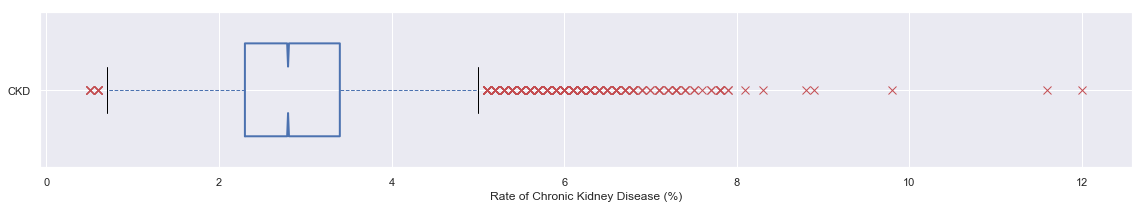

In [140]:
plt.figure(figsize=(16,3))
cdc_full.boxplot(column='CKD', vert=False, widths=(.6), notch=True,
                 boxprops={'linestyle':'-','linewidth':2},
                 whiskerprops={'linestyle':'--'},
                 flierprops={'markeredgecolor':'r', 'marker':'x','markersize':8},
                 medianprops={'linewidth':0})

plt.xlabel('Rate of Chronic Kidney Disease (%)')
plt.tight_layout()

In [141]:
# print summary info on any missing data
print('Missing Data')
print('-'*50)
n = 28004

for key, val in dict(cdc_df.MeasureId.value_counts()).items():
    if n - val > 0:
        print(key + ' : ' + str(n - val) + ' | ' + '{:.2f}'.format((n-val)/n*100) + '%')

Missing Data
--------------------------------------------------
ACCESS2 : 33 | 0.12%
PAPTEST : 94 | 0.34%
COLON_SCREEN : 159 | 0.57%
MAMMOUSE : 279 | 1.00%
TEETHLOST : 405 | 1.45%
COREM : 542 | 1.94%
COREW : 553 | 1.97%


In [142]:
complete_df.shape

(27408, 256)